<a href="https://colab.research.google.com/github/Tstrebe2/predicting-text-difficulty/blob/dave-updates/code/dave-Sentence-Embedding-Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [213]:
import pandas as pd
import numpy as np
import spacy
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.decomposition import KernelPCA

In [216]:
%pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [217]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [218]:
train = pd.read_csv('drive/Shareddrives/Milestone 2/Training_set.csv', 
                      sep='\t',index_col='ix')
# train['lemmatized_text'] = train['lemmatized_text'].fillna('')
train['lemmatized_text'] = train['lemmatized_text'].astype(str)

In [219]:
sample_df = train.groupby('label').apply(lambda x: x.sample(2500, random_state=99))

In [220]:
sample_df.label.value_counts()

0    2500
1    2500
Name: label, dtype: int64

In [221]:
nlp = spacy.load("en_core_web_sm")

In [222]:
sample_df['embedding'] =  (sample_df['lemmatized_text']
                           .apply(lambda doc: nlp(doc).vector))

X = pd.DataFrame([x for x in sample_df['embedding']])

In [223]:
# My gridsearch-ish attempt at running k-means

def find_best_kmeans(X,n_clus_lst):
 
  m = {'cluster':[],
       'score':[],
       'best_model':None}

  for idx, n in enumerate(n_clus_lst):
    km = KMeans(n_clusters=n,max_iter=500,
                random_state=99)
    km.fit(X)
    score = silhouette_score(X,km.labels_,
                    random_state=99)
    m['cluster'].append(n)
    m['score'].append(score)
    if m['best_model'] is None:
      m['best_model'] = km
    elif score > np.max(m['score']):
      m['best_model'] = km
  return m


def plot_clusters(feature_one, feature_two, labels,title):
  plt.figure(figsize=(10,10))
  plt.title(title)
  plt.xlabel("PCA Feature 1")
  plt.ylabel("PCA Feature 2")
  sns.scatterplot(x=feature_one,
                  y=feature_two,
                  hue=labels,
                  alpha=.3,
                  );

In [245]:
X_std = StandardScaler().fit_transform(X)

In [246]:
X_pca = PCA(n_components=5).fit_transform(X_std)

In [247]:
import seaborn as sns

Best Score: 0.6093863248825073


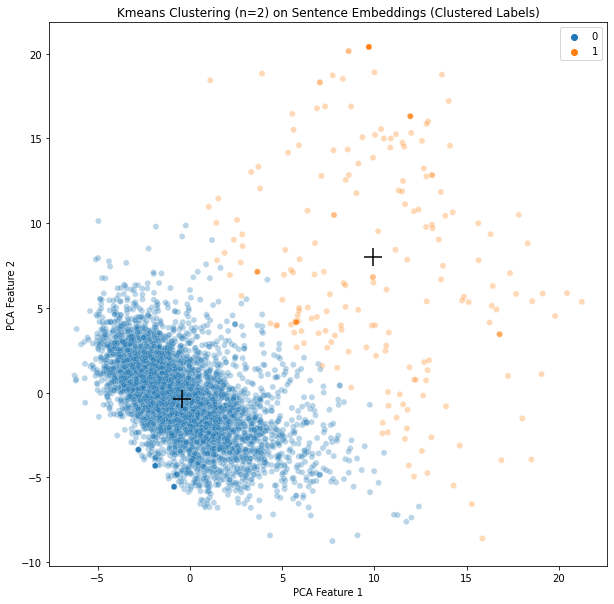

In [249]:
results = find_best_kmeans(X_pca, [x for x in range(2,10)])
print(f"Best Score: {np.max(results['score'])}")
centers = np.array(results['best_model'].cluster_centers_)

km = results['best_model']
feat_one = X_pca[:,0]
feat_two = X_pca[:,1]
title = f"Kmeans Clustering (n={km.n_clusters}) on Sentence Embeddings (Clustered Labels)"
plot_clusters(feat_one,
              feat_two,
              km.labels_, title)

#plot cluster centers
plt.scatter(centers[:,0], centers[:,1], marker="+",
            color='black', s=300)


In [250]:
# k-means found cluster separation however, the Silo score is around .5, 
# which doesn't imply great clustering separation.
# The plus signs are the respective cluster centers. Looking at what 
# sentences are clustered close by the centers for additional information

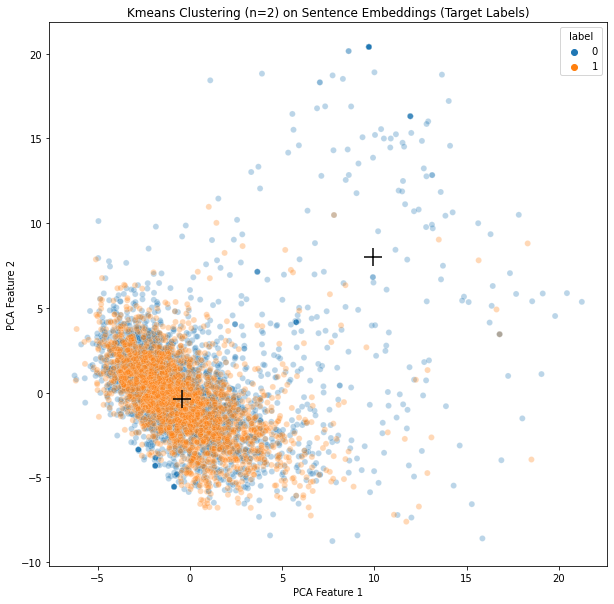

In [251]:
plt.figure(figsize=(10,10))
plt.title(f"Kmeans Clustering (n={km.n_clusters}) on Sentence Embeddings (Target Labels)")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")

g =sns.scatterplot(x=X_pca[:,0],
                y=X_pca[:,1],
                hue=sample_df.label,
                alpha=.3,
                legend='full')

#plot cluster centers
plt.scatter(centers[:,0], centers[:,1], marker="+", 
            color='black',s=300);

In [252]:
#code modified from https://stackoverflow.com/questions/69164379/how-to-find-the-index-of-the-point-closest-to-k-means-cluster-centers-using-skle
from scipy.spatial.distance import euclidean

def top_sentences_by_cluster(X,km,df):
  closest_pt_idx = []
  for iclust in range(km.n_clusters):
      # get all points assigned to each cluster:
      cluster_pts = X[km.labels_ == iclust]
      # get all indices of points assigned to this cluster:
      cluster_pts_indices = np.where(km.labels_ == iclust)[0]

      cluster_cen = km.cluster_centers_[iclust]
      top = np.argsort([euclidean(X[idx], cluster_cen) for idx in cluster_pts_indices])[:10]

      # Print out the results for each cluster
      print(f" ")
      print(f'top 10 closest sentences to cluster {iclust}\'s center:')
      for sent_vec in top:
        print(df.iloc[cluster_pts_indices[sent_vec]]['original_text'])


In [253]:
top_sentences_by_cluster(X_pca,km,sample_df)

 
top 10 closest sentences to cluster 0's center:
List of moons The Neptunian moons are listed here by its orbital period , from shortest to longest .
The film is directed by Guillermo del Toro and is a sequel to the 2004 film Hellboy , which del Toro also directed .
Gavialidae consists of only one surviving species , the gharial -LRB- Gavialis gangeticus -RRB- , which is native to India .
David Francis , the President of the Louisiana Purchase Exposition , did not invite anybody else to open the games and , on July 1 , 1904 , did so himself in a small , short ` ceremony ' .
There are a few hills around Bloemfontein .
She had to take up the role of the First Lady as the President 's wife , Ellen Lewis Herndon Arthur , had died about one and half year earlier .
2006 & ndash ; Lebanon War : At least 28 civilians , including 16 children are killed by the Israeli Air Force in what Lebanese call the Second Qana massacre and what Israel considers to be an attempt to stop rockets ' being fire

In [254]:
# It appears the K-Means algorithm found clusters based on 
# sentence length for the sentence embeddings.  
# Cluster 2 appears to only have 1 word in the original text

In [255]:
sample_df['emb_member'] = km.labels_

In [243]:
sample_df.head()

original_text  \
label ix                                                          
0     256892  He studied art in Berlin , Essen , and Munich ...   
      302461  There are paw prints of cave bears . There are...   
      336641  The album also won the band a 2003 Swedish Gra...   
      336467                      Communist Hungary , 1946-1989   
      413140  Both his teaching and his textbook were instru...   

                                                lemmatized_text  \
label ix                                                          
0     256892  he study art in berlin essen and munich before...   
      302461  there be paw print of cave bear there be also ...   
      336641  the album also win the band a 2003 swedish gra...   
      336467                         communist hungary 19461989   
      413140  both he teach and he textbook be instrumental ...   

              d_chall_score   aoa_mean  aoa_min  aoa_max  conc_rating_mean  \
label ix                                                                     
0     256892       8.097500   5.320769     2.89    12.22          2.663077   
      302461       1.780475   5.568750     3.58    10.71          2.933333   
      336641       6.714850   5.029231     2.89     7.74          2.855833   
      336467      15.938800  13.220000    13.22    13.22          3.500000   
      413140       8.356977   6.015652     2.89    11.84          2.730909   

              conc_rating_min  conc_rating_max  num_lemmas  label  \
label ix                                                            
0     256892             1.33             4.92        20.0      0   
      302461             1.43             4.96        16.0      0   
      336641             1.43             4.91        16.0      0   
      336467             3.50             3.50         3.0      0   
      413140             1.43             4.93        27.0      0   

                                                      embedding  emb_member  
label ix                                                                     
0     256892  [0.018231928, 0.4154876, 0.7377034, -0.2962893...           0  
      302461  [0.12793973, 0.08198082, 0.033817958, -0.48279...           0  
      336641  [0.5794473, 0.06901185, 0.021388948, 0.0367541...           0  
      336467  [0.6379275, 0.23654538, 0.6577674, -0.6533095,...           1  
      413140  [0.15669607, 0.13308333, 0.42378902, 0.0137577...           0

In [256]:
metrics = {'gamma': [],
           'clusters': [],
           'score': []
           }

for g in [.001,.01,1, 10,100]:
  X_kpca = KernelPCA(n_components=5, gamma=g).fit_transform(X_std)
  results = find_best_kmeans(X_kpca, [x for x in range(2,10)])
  for idx, score in enumerate(results['score']):
    metrics['gamma'].append(g)
    metrics['clusters'].append(results['cluster'][idx])
    metrics['score'].append(score)

metrics_df = pd.DataFrame(metrics)

In [257]:
metrics_df.sort_values('score', ascending=False)[:5]

,gamma,clusters,score
16,1.000,2,0.609384
0,0.001,2,0.609384
32,100.000,2,0.609384
8,0.010,2,0.609384
24,10.000,2,0.609384


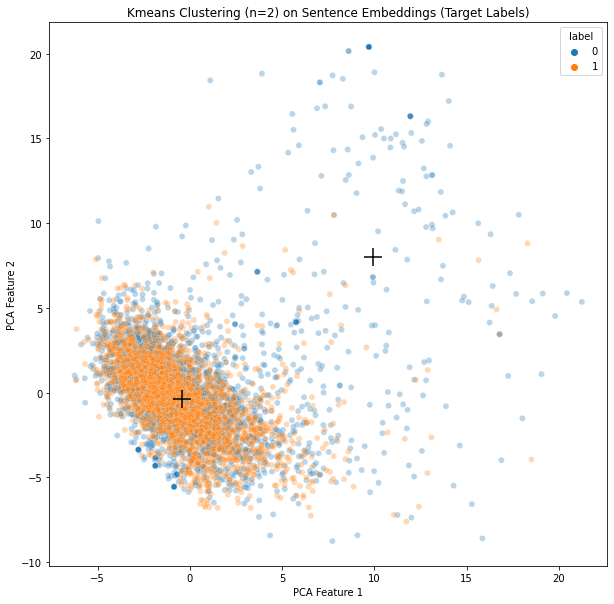

In [ ]:
X_kpca = KernelPCA(n_components=5).fit_transform(X_std)
results = find_best_kmeans(X_kpca, [x for x in range(2,10)])
centers = np.array(results['best_model'].cluster_centers_)

km = results['best_model']
plt.figure(figsize=(10,10))
plt.title(f"Kmeans Clustering (n={km.n_clusters}) on Sentence Embeddings (Target Labels)")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")

g =sns.scatterplot(x=X_pca[:,0],
                y=X_pca[:,1],
                hue=sample_df.label,
                alpha=.3,
                legend='full')

#plot cluster centers
plt.scatter(centers[:,0], centers[:,1], marker="+", 
            color='black',s=300);

In [ ]:
top_sentences_by_cluster(X_kpca,km,sample_df)

 
top 10 closest sentences to cluster 0's center:
List of moons The Neptunian moons are listed here by its orbital period , from shortest to longest .
The film is directed by Guillermo del Toro and is a sequel to the 2004 film Hellboy , which del Toro also directed .
Gavialidae consists of only one surviving species , the gharial -LRB- Gavialis gangeticus -RRB- , which is native to India .
David Francis , the President of the Louisiana Purchase Exposition , did not invite anybody else to open the games and , on July 1 , 1904 , did so himself in a small , short ` ceremony ' .
There are a few hills around Bloemfontein .
She had to take up the role of the First Lady as the President 's wife , Ellen Lewis Herndon Arthur , had died about one and half year earlier .
2006 & ndash ; Lebanon War : At least 28 civilians , including 16 children are killed by the Israeli Air Force in what Lebanese call the Second Qana massacre and what Israel considers to be an attempt to stop rockets ' being fire

In [ ]:
#!pip install ipympl

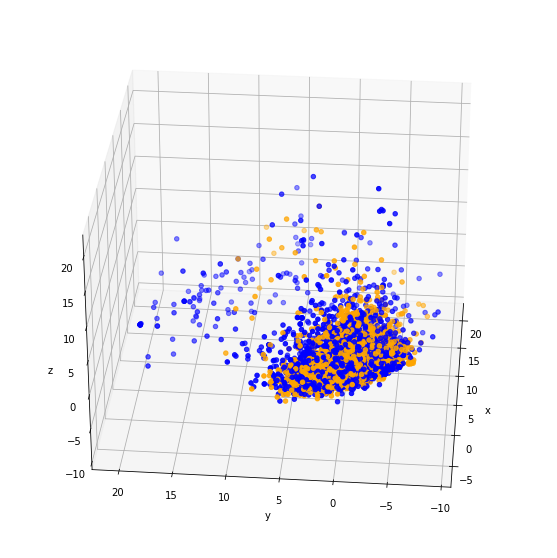

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# from mpl_toolkits import mplot3d
# %matplotlib widget

cmap = matplotlib.colors.ListedColormap(['blue', 'orange'])
plt.figure(figsize=(10,10))
axes = plt.axes(projection='3d')
axes.scatter3D(X_pca[:,0], X_pca[:,1],X_pca[:,2,],
               c=sample_df.label, cmap=cmap)

axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_zlabel('z')
axes.view_init(30, 185)
plt.show()



In [ ]:
import plotly.express as px


fig = px.scatter_3d(sample_df, x=X_pca[:,0], y=X_pca[:,1], z=X_pca[:,2],
              color='label')
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000)

fig.show()

# K-Means Clustering on Tfidf Vectorized Text

In [258]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [259]:
vec = TfidfVectorizer( min_df=20,
                      ngram_range=(1,3)
                      )
X_vec = vec.fit_transform(sample_df['lemmatized_text'])
X_vec_PCA = PCA(n_components=5).fit_transform(X_vec.toarray())

In [260]:
n_clust_lst = [x for x in range(2,11)]
tf_results = find_best_kmeans(X_vec_PCA,n_clust_lst)

In [ ]:
tf_results

{'cluster': [2, 3, 4, 5, 6, 7, 8, 9, 10],
 'score': [0.3502954557217614,
  0.39016667464732474,
  0.29140696914484326,
  0.3193035420582798,
  0.259653259061888,
  0.2577439650141051,
  0.26945999374966784,
  0.26970390452109744,
  0.2717220420851382],
 'best_model': KMeans(n_clusters=2, random_state=99)}

Best Score (tfidf): 0.6093838810920715


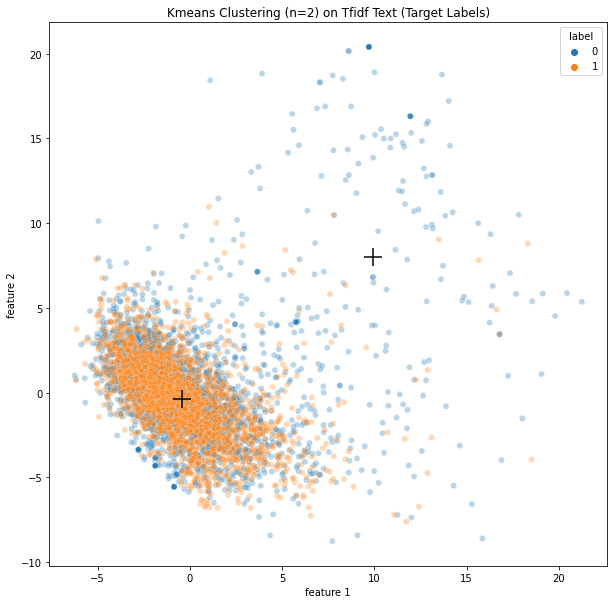

In [261]:
print(f"Best Score (tfidf): {np.max(results['score'])}")
plt.figure(figsize=(10,10))
plt.title(f"Kmeans Clustering (n={km.n_clusters}) on Tfidf Text (Target Labels)")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
sns.scatterplot(x=X_pca[:,0],
                y=X_pca[:,1],
                hue=sample_df.label,
                alpha=.3)

#plot cluster centers
plt.scatter(centers[:,0], centers[:,1], marker="+", 
            color='black',s=300);

In [ ]:
top_sentences_by_cluster(X_vec_PCA,km,sample_df)

 
top 10 closest sentences to cluster 0's center:
Oxygen was independently discovered by Carl Wilhelm Scheele , in Uppsala , in 1773 or earlier , and Joseph Priestley in Wiltshire , in 1774 , but Priestley is often given priority because his publication came out in print first .
They obtained independence in 1960 .
After receiving a first prize in organ performance and improvisation in 1941 , Jeanne Demessieux studied five more years with Dupré in Meudon , before she played her début recital at Salle Pleyel in Paris in 1946 .
This happens at about 1 bit in 1015 in enterprise-class disk drives , and 1 bit in 1014 in ordinary disk drives .
This season was also the first to have a tiebreaker challenge : in , the person that had most votes against them in earlier Tribal Councils was voted out in such a situation , but in Samburus first tribal council , Carl Bilancione and Lindsey Richter each had four votes .
In The Brothers Karamazov , the character Dimitri Karamazov asks his atheist frie

# Numeric Features

In [ ]:
num_features = ['d_chall_score', 'aoa_mean',
       'aoa_min', 'aoa_max', 'conc_rating_mean', 'conc_rating_min',
       'conc_rating_max', 'num_lemmas']

In [ ]:
si = SimpleImputer(missing_values=np.nan, strategy='mean')
X_num = si.fit_transform(sample_df[num_features])
X_num_std = StandardScaler().fit_transform(X_num)


In [ ]:
metrics = find_best_kmeans(X_num_std,[2,3,4,5,6,7,8])

In [ ]:
metrics

{'cluster': [2, 3, 4, 5, 6, 7, 8],
 'score': [0.578215750326415,
  0.5827496800305163,
  0.1915945984651341,
  0.22061948770636472,
  0.2286004387003079,
  0.20774957793808052,
  0.19839061540106112],
 'best_model': KMeans(n_clusters=2, random_state=99)}

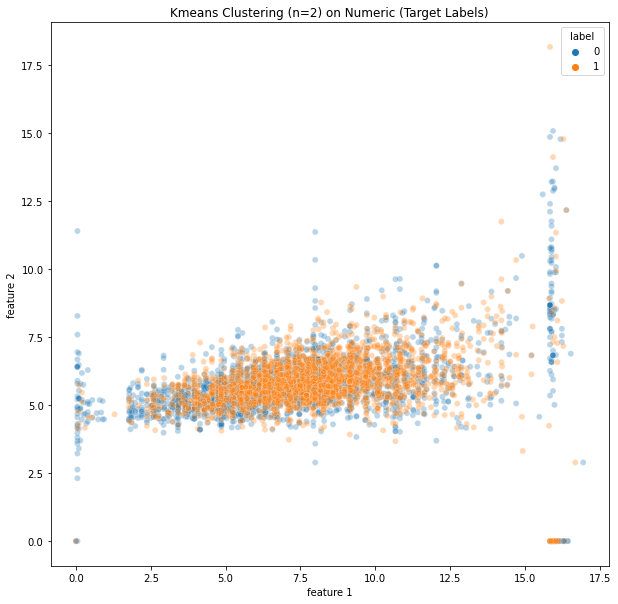

In [ ]:
c_labels = metrics['best_model'].labels_
plt.figure(figsize=(10,10))
plt.title(f"Kmeans Clustering (n={km.n_clusters}) on Numeric (Target Labels)")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
sns.scatterplot(x=sample_df['d_chall_score'],
                y=sample_df['aoa_mean'],
                hue=sample_df.label,
                alpha=.3);


(5000, 8)

# Using UMAP For Dimensionality-Reduction

In [262]:
import umap

In [263]:
# Code obtained and slightly modified from https://umap-learn.readthedocs.io/en/latest/parameters.html

def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    data=X_std
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data)
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)),c=data[:,0])
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c=data[:,0])
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2])
    plt.title(title, fontsize=18)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


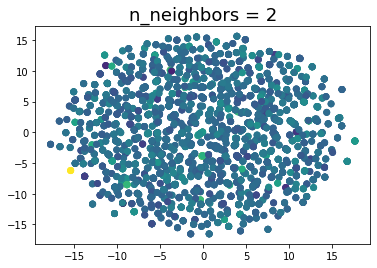

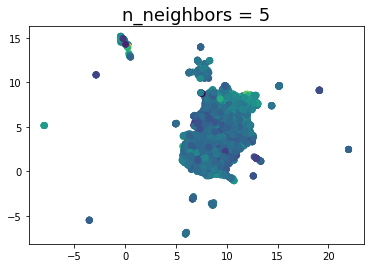

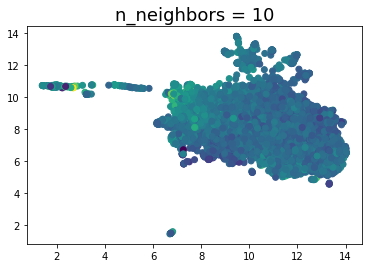

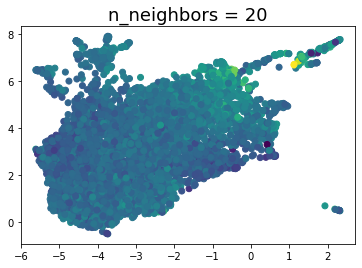

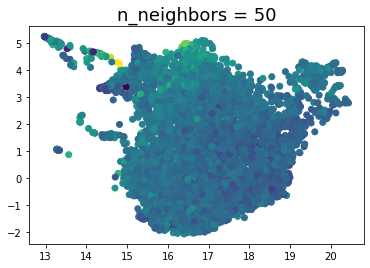

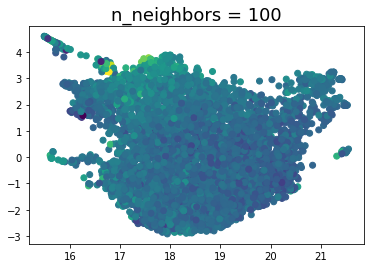

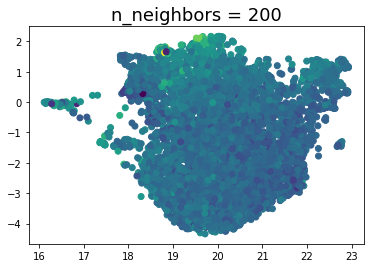

In [264]:
# reducer = umap.UMAP(n_neighbors=5, n_components=2)
# embs = reducer.fit_transform(X_std)

for n in (2, 5, 10, 20, 50, 100, 200):
    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))

In [279]:
# %pip install umap-learn
# %pip install "umap-learn[plot]"

In [272]:
import umap.plot

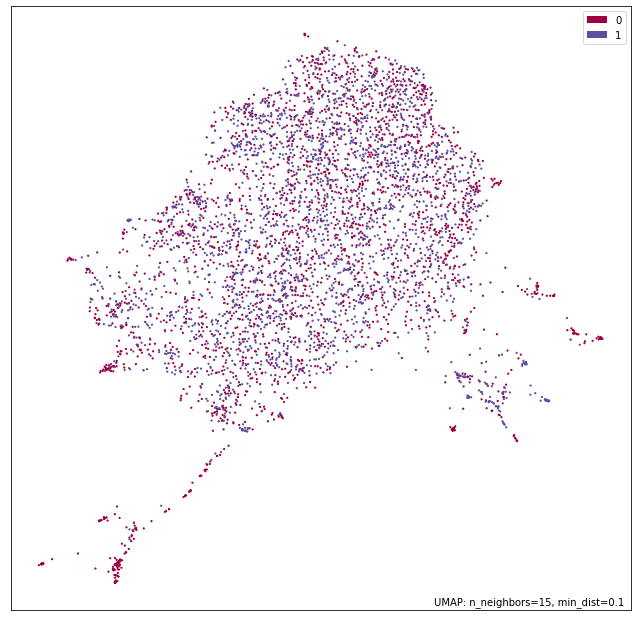

In [277]:
mapper = umap.UMAP().fit(X_std)
umap.plot.points(mapper,labels=sample_df.label)

In [ ]:
from sklearn.manifold import TSNE

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


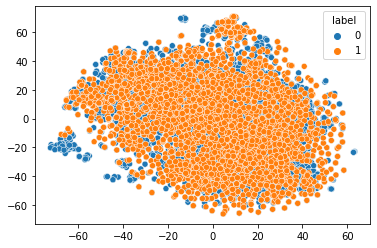

In [ ]:
for lr in [10,100,500,1000]:
  tsne= TSNE(learning_rate = lr,
             random_state=99,
             n_jobs=-1)
  X_tsne = tsne.fit_transform(X_std)
  
  
  
  sns.scatterplot(X_tsne[:,0],X_tsne[:,1], hue=sample_df['label'] )